In [1]:
import scanpy as sc 
import pandas as pd 
import numpy as np 

In [2]:
import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT, spatial_match
from scSLAT.viz import match_3D_multi, hist, Sankey

/ix/djishnu/alw399/envs/slat/lib/python3.11/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.27' not found (required by /ix/djishnu/alw399/envs/slat/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/ix/djishnu/alw399/envs/slat/lib/python3.11/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.27' not found (required by /ix/djishnu/alw399/envs/slat/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [3]:
test_adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_visiumHD_subsampled.h5ad')
test_adata

AnnData object with n_obs × n_vars = 10000 × 3058
    obs: 'ct3', 'cell_type'
    uns: 'cell_type_colors', 'log1p'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    layers: 'corrected_count', 'imputed_count', 'normalized_count', 'raw_count'

In [4]:
ref_adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_13.h5ad')
ref_adata

AnnData object with n_obs × n_vars = 8509 × 3058
    obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [5]:
ref_embed = pd.read_parquet('/ix/djishnu/shared/djishnu_kor11/banksy_outputs/mouse_kidney_13_embedding.parquet')
ref_embed.shape

(8509, 9174)

In [6]:
test_embed = pd.read_parquet('/ix/djishnu/shared/djishnu_kor11/banksy_outputs/mouse_kidney_visiumHD_subsampled_embedding.parquet')
test_embed.shape

(10000, 9174)

In [7]:
xI = test_adata.obsm['spatial'][:, 0]
yI = test_adata.obsm['spatial'][:, 1]
xJ = ref_adata.obsm['spatial'][:, 0]
yJ= ref_adata.obsm['spatial'][:, 1]

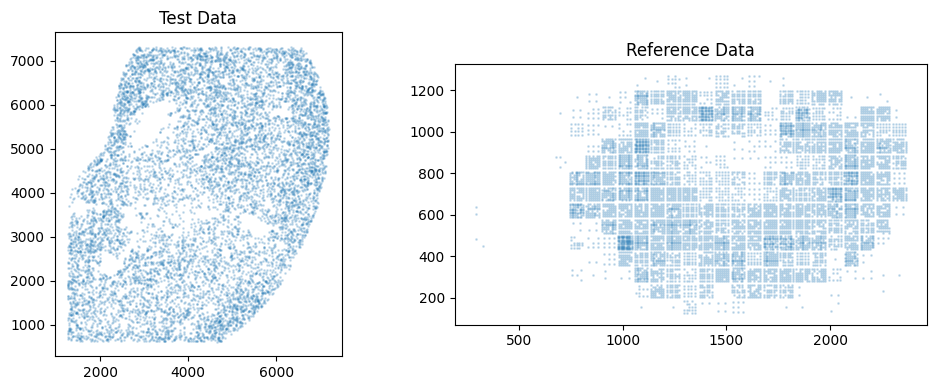

In [8]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot test data
ax1.scatter(xI, yI, s=1, alpha=0.2)
ax1.set_title('Test Data')
ax1.set_aspect('equal')

# Plot reference data  
ax2.scatter(xJ, yJ, s=1, alpha=0.2)
ax2.set_title('Reference Data')
ax2.set_aspect('equal')

plt.tight_layout()


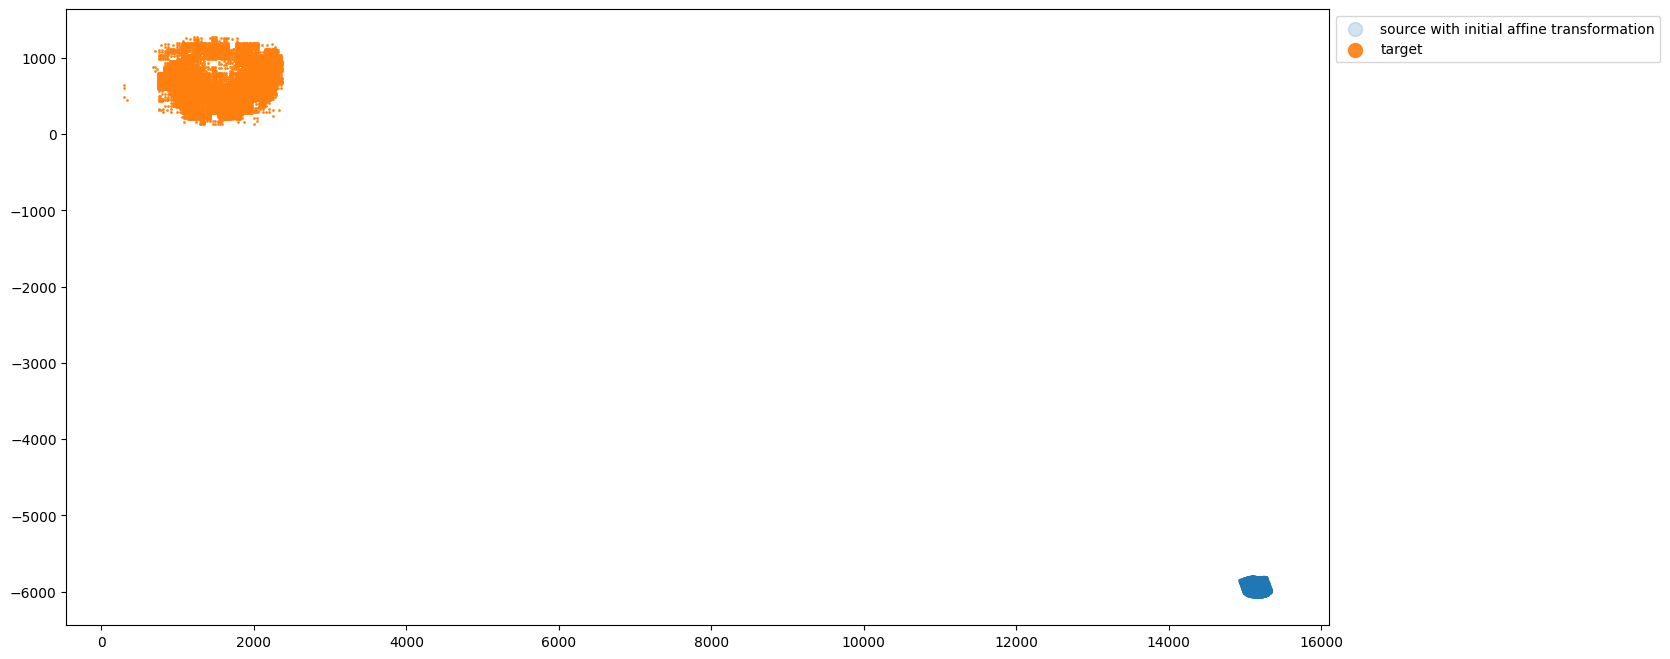

In [9]:
import matplotlib.pyplot as plt 

theta_deg = 70
theta0 = (np.pi/180)*-theta_deg

#rotation matrix
#rotates about the origin
L = np.array([[np.cos(theta0),-np.sin(theta0)],
              [np.sin(theta0),np.cos(theta0)]])

source_L = np.matmul(L , np.array([xI, yI]))
xI_L = source_L[0] 
yI_L = source_L[1] 

#translation matrix
#effectively makes the rotation about the centroid of I (i.e the means of xI and yI])
#and also moves the centroid of I to the centroid of J
T = np.array([ np.mean(xI)- np.cos(theta0)*np.mean(xI) +np.sin(theta0)*np.mean(yI) - (np.mean(xI)-np.mean(xJ)),
              np.mean(yI)- np.sin(theta0)*np.mean(xI) -np.cos(theta0)*np.mean(yI) - (np.mean(yI)-np.mean(yJ))])

shrink = 1/19
xI_L_T = xI_L * shrink + T[0] + 1.87e4
yI_L_T = yI_L * shrink + T[1] - 9.15e3


fig,ax = plt.subplots(figsize=(25,8))
ax.scatter(xI_L_T,yI_L_T,s=1,alpha=0.2, label='source with initial affine transformation')
ax.scatter(xJ,yJ,s=1,alpha=0.9, label = 'target')
ax.legend(markerscale = 10, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_aspect('equal', adjustable='box')

In [10]:
# doesnt have to be perfect since SLAT doesn't need them to be aligned
# it's just easier to find a good crop

test_adata.obsm['spatial'] = np.stack([xI_L_T, yI_L_T]).T

In [11]:
adata2 = test_adata 
adata1 = ref_adata

adata1, adata2

(AnnData object with n_obs × n_vars = 8509 × 3058
     obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
     uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
     varm: 'PCs'
     layers: 'imputed_count', 'normalized_count', 'raw_count'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 10000 × 3058
     obs: 'ct3', 'cell_type'
     uns: 'cell_type_colors', 'log1p'
     obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
     layers: 'corrected_count', 'imputed_count', 'normalized_count', 'raw_count')

### Use the Banksy embedding as features

In [12]:
test_embed = test_embed.reindex(test_adata.obs.index, axis=0)
test_embed = test_embed.reindex(ref_embed.columns, axis=1)

ref_embed = ref_embed.reindex(ref_adata.obs.index, axis=0)

In [13]:
test_adata = sc.AnnData(
    X = test_embed.values,
    obs = test_adata.obs,
    var = pd.DataFrame(index=test_embed.columns),
    obsm = test_adata.obsm
)

ref_adata = sc.AnnData(
    X = ref_embed.values,
    obs = ref_adata.obs,
    var = pd.DataFrame(index=ref_embed.columns),
    obsm = ref_adata.obsm
)

In [14]:
test_adata.X.max(), ref_adata.X.max()

(24.232786178588867, 55.80235290527344)

In [15]:
test_adata.X.min(), ref_adata.X.min()

(-4.916860103607178, -6.766073226928711)

### Batch correct?

In [16]:
adata2 = test_adata 
adata1 = ref_adata

adata1, adata2

(AnnData object with n_obs × n_vars = 8509 × 9174
     obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
     obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled',
 AnnData object with n_obs × n_vars = 10000 × 9174
     obs: 'ct3', 'cell_type'
     obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled')

/tmp/ipykernel_43264/1997364145.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = adata1.concatenate(adata2)
2025-05-18 20:47:19,203 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-18 20:47:24,164 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-18 20:47:24,186 - harmonypy - INFO - Iteration 1 of 10
2025-05-18 20:47:25,646 - harmonypy - INFO - Iteration 2 of 10
2025-05-18 20:47:26,908 - harmonypy - INFO - Converged after 2 iterations


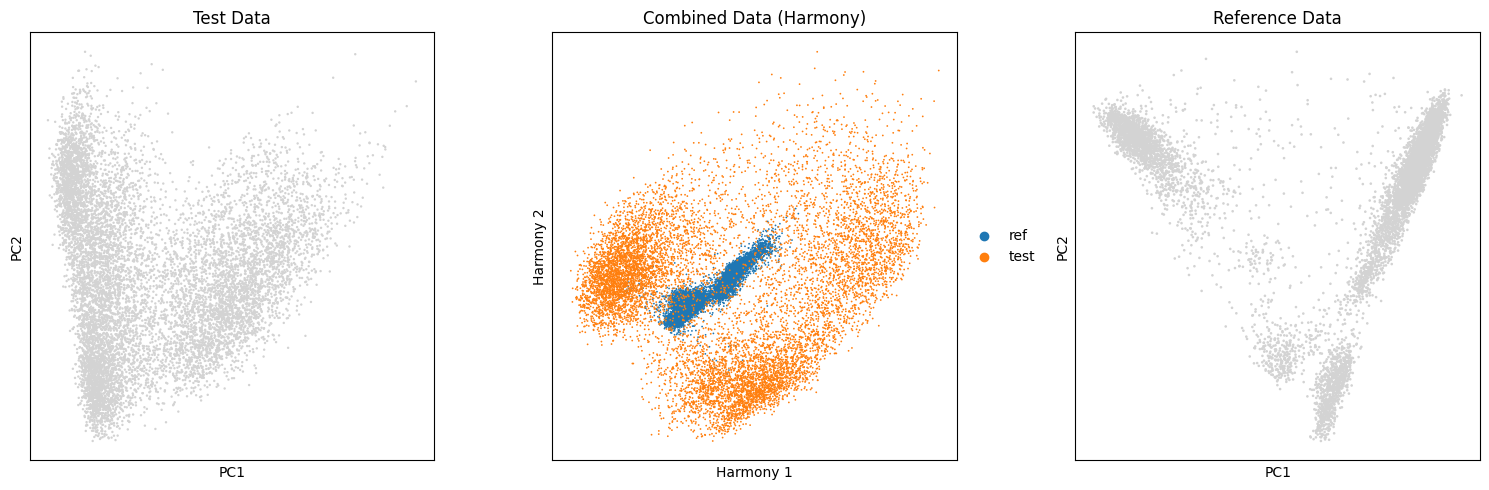

In [17]:
# Concatenate the adatas
adata_concat = adata1.concatenate(adata2)

# Add batch info
adata_concat.obs['batch'] = ['ref' if i < len(adata1) else 'test' for i in range(len(adata_concat))]

# Run PCA
sc.tl.pca(adata_concat)

# Run Harmony
import harmonypy as hp
ho = hp.run_harmony(adata_concat.obsm['X_pca'], adata_concat.obs, ['batch'])
adata_concat.obsm['X_harmony'] = ho.Z_corr.T

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot test data
sc.pl.pca(test_adata, show=False, ax=ax1, title='Test Data')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

# Plot combined data colored by batch
sc.pl.embedding(adata_concat, 'X_harmony', color='batch', show=False, ax=ax2, title='Combined Data (Harmony)')
ax2.set_xlabel('Harmony 1') 
ax2.set_ylabel('Harmony 2')

# Plot reference data
sc.pl.pca(ref_adata, show=False, ax=ax3, title='Reference Data')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')

plt.tight_layout()
plt.show()


In [18]:
pd.DataFrame(
    adata_concat.obsm['X_harmony'], 
    index=adata_concat.obs.index,
    columns=[f'X_harmony_{i}' for i in range(50)]
).to_csv('banksy_subsampled_harmony.csv')

In [19]:
test_adata = sc.AnnData(
    X = adata_concat[test_adata.obs.index + '-1'].obsm['X_harmony'],
    obs = test_adata.obs,
    var = [f'X_harmony_{i}' for i in range(50)],
    obsm = test_adata.obsm
)

ref_adata = sc.AnnData(
    X = adata_concat[ref_adata.obs.index + '-0'].obsm['X_harmony'],
    obs = ref_adata.obs,
    var = [f'X_harmony_{i}' for i in range(50)],
    obsm = ref_adata.obsm
)

### Run scSLAT

In [20]:
adata2 = test_adata
adata1 = ref_adata

adata1.X.min(), adata2.X.min()

(array(-29.45593, dtype=float32), array(-50.78176, dtype=float32))

In [21]:
Cal_Spatial_Net(adata1, k_cutoff=10, model='KNN')
Cal_Spatial_Net(adata2, k_cutoff=10, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 94277 edges, 8509 cells.
11.079680338465154 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 113842 edges, 10000 cells.
11.3842 neighbors per cell on average.


/tmp/ipykernel_43264/1288634013.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata1, color="cell_type", spot_size=10)


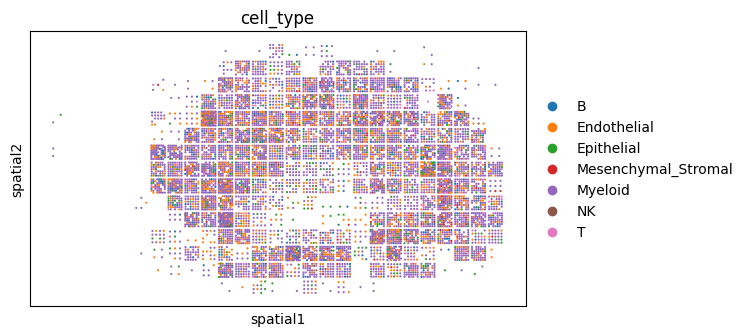

/tmp/ipykernel_43264/1288634013.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata2, color="cell_type", spot_size=10)


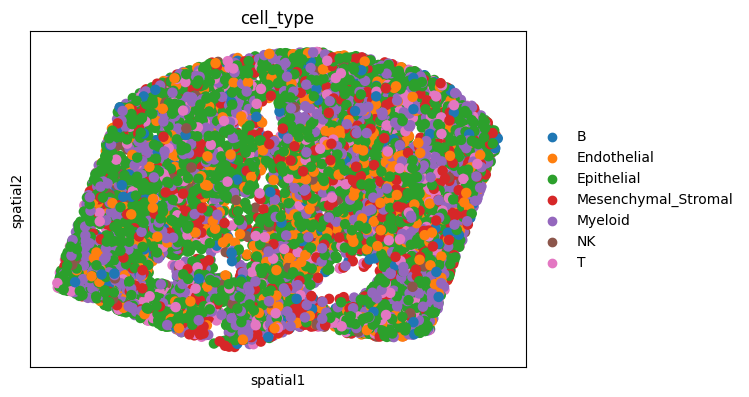

In [22]:
sc.pl.spatial(adata1, color="cell_type", spot_size=10)
sc.pl.spatial(adata2, color="cell_type", spot_size=10)

In [23]:
edges, features = load_anndatas([adata1, adata2], feature='raw', check_order=False)

Use raw feature to format graph


In [24]:
embd0, embd1, time = run_SLAT(features, edges)

GPU is not available
Running
Training model time: 99.13


In [25]:
best, index, distance = spatial_match([embd0, embd1], adatas=[adata1,adata2], reorder=False)

In [26]:
adata1.obs['annotation'] = adata1.obs['cell_type']
adata2.obs['annotation'] = adata2.obs['cell_type']

In [27]:
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata1.obsm['spatial'][:,0],
                        'y': adata1.obsm['spatial'][:,1],
                        'celltype': adata1.obs['annotation']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata2.obsm['spatial'][:,0],
                        'y': adata2.obsm['spatial'][:,1],
                        'celltype': adata2.obs['annotation']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

dataset1: 7 cell types; dataset2: 7 cell types; 
                    Total :7 celltypes; Overlap: 7 cell types 
                    Not overlap :[[]]
Subsampled 300 pairs from 10000


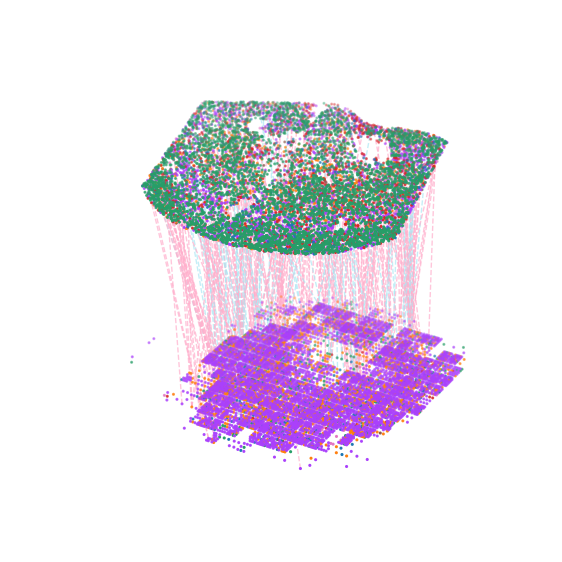

In [28]:
multi_align = match_3D_multi(adata1_df, adata2_df, matching,meta='celltype',
                            scale_coordinate=True, subsample_size=300)
multi_align.draw_3D(size=[7, 8], line_width=1, point_size=[1.5,1.5], hide_axis=True)

In [29]:
matching

array([[   0,    1,    2, ..., 9997, 9998, 9999],
       [3479, 4315, 4319, ..., 5286, 1924, 5833]])

In [30]:
test_cells = np.array(test_adata.obs_names)[matching[0]]
ref_cells = np.array(ref_adata.obs_names)[matching[1]]

pd.DataFrame(ref_cells, index=test_cells, columns=['reference_cell']).to_csv('matching_slat_banksy_subsampled.csv')

### Check mapping

In [31]:
mapping = pd.read_csv('matching_slat_banksy_subsampled.csv', index_col=0)
mapping.shape

(10000, 1)

In [32]:
mapping['reference_cell'].value_counts()

CATTGAGCACGGATCC-13    288
GTGAGTTTCTAGCATG-13    245
GACTTCCGTCAGGAGT-13    240
GGGTCTGGTGACATCT-13    240
TCATGTTCAGTATTCG-13    226
                      ... 
AGGACGAGTTCAAGTC-13      1
CTGAATGCACAGTACT-13      1
CTCCTCCTCTCCTACG-13      1
TGTGTGAAGGTCCAGA-13      1
GTAACCAGTAGTCGGA-13      1
Name: reference_cell, Length: 1746, dtype: int64

In [33]:
mapping['ref_cell_type'] = mapping['reference_cell'].map(ref_adata.obs['cell_type'])
mapping['test_cell_type'] = mapping.index.map(test_adata.obs['cell_type'])


In [34]:
df3 = mapping

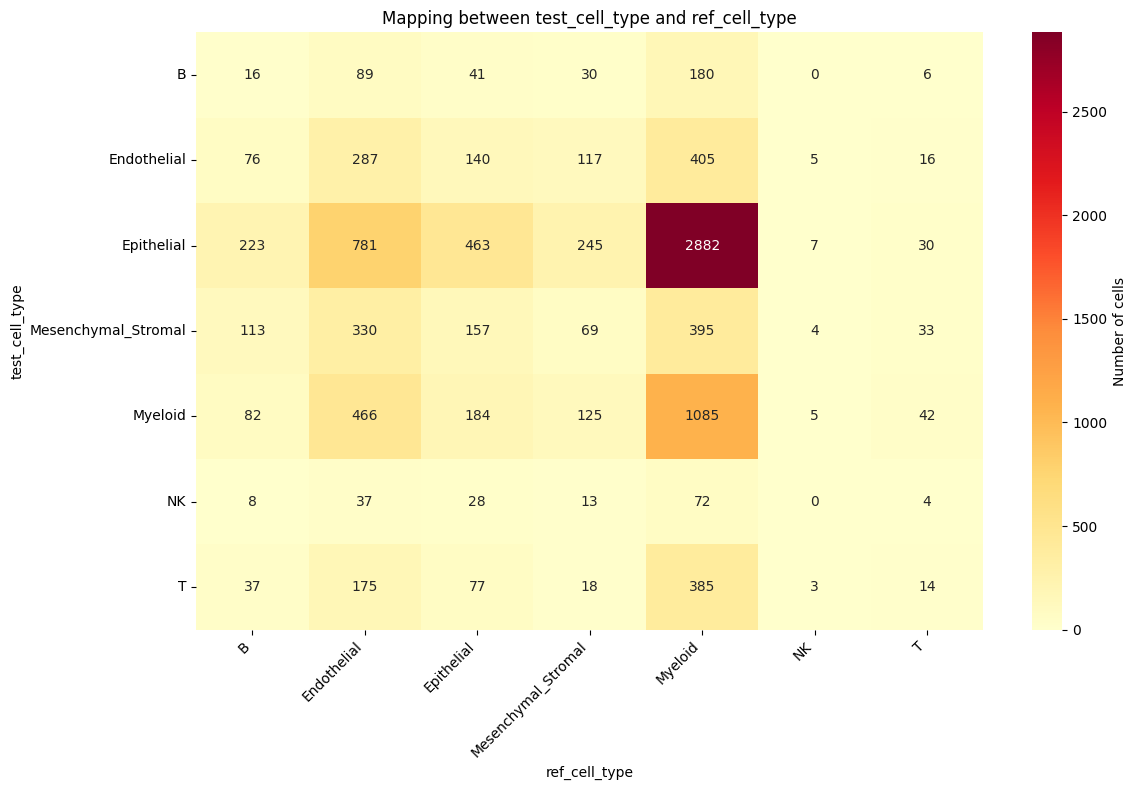

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create heatmap data
heatmap_data = df3.groupby(['test_cell_type', 'ref_cell_type']).size().unstack(fill_value=0)

# Create figure
plt.figure(figsize=(12, 8))

# Create heatmap
sns.heatmap(heatmap_data, 
            annot=True,  # Show numbers in cells
            fmt='d',     # Format as integers
            cmap='YlOrRd',  # Color scheme
            cbar_kws={'label': 'Number of cells'})

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add title and adjust layout
plt.title('Mapping between test_cell_type and ref_cell_type')
plt.tight_layout()

plt.show()

In [36]:
colors = ["#6588cd",
"#75ab3d",
"#ab62c0",
"#54a77a",
"#c85979",
"#b49142",
"#cc5d38"]
color_dict = dict(zip(test_adata.obs['cell_type'].unique(), colors))

In [37]:
mapping

,reference_cell,ref_cell_type,test_cell_type
ID_167606,CGTTAGAAGTTCCTGA-13,Myeloid,Myeloid
ID_103875,GACTTCCGTCAGGAGT-13,Endothelial,Epithelial
ID_276156,GAGAAATAGAAATTGC-13,Endothelial,Mesenchymal_Stromal
ID_169310,GTCTGTCAGAAACTGT-13,Mesenchymal_Stromal,Mesenchymal_Stromal
ID_341987,TTTGACTCAGTTACCA-13,Endothelial,Endothelial
...,...,...,...
ID_70566,AGTCATGTCGCAGATT-13,Myeloid,Epithelial
ID_326001,GTTACAGAGTTAACAG-13,T,NK
ID_314503,GGGCTCAGTCAGCTTA-13,Myeloid,Mesenchymal_Stromal
ID_255802,ATTATCCGTATTCCTT-13,Endothelial,Mesenchymal_Stromal


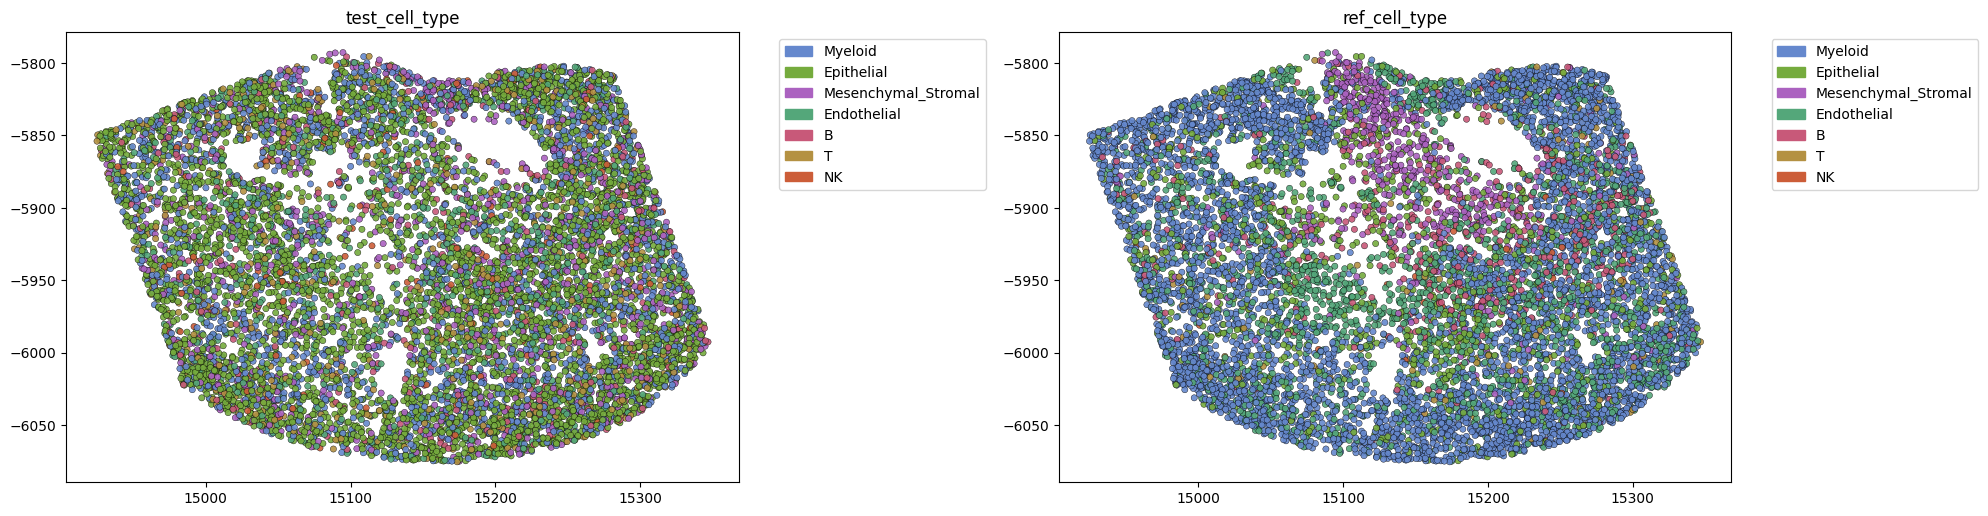

In [38]:
import matplotlib.patches as mpatches
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Create legend patches
legend_patches = [mpatches.Patch(color=color, label=cell_type) 
                 for cell_type, color in color_dict.items()]

# Plot test cell types
test_colors = [color_dict[ct] for ct in test_adata.obs['cell_type'].reindex(mapping.index)]
axs[0].scatter(
    test_adata.obsm['spatial'][:, 0],
    test_adata.obsm['spatial'][:, 1],
    s=20,
    alpha=0.9,
    c=test_colors,
    edgecolor='black',
    linewidth=0.3
)
axs[0].set_title('test_cell_type')
axs[0].set_aspect('equal')
axs[0].legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot ref cell types  
ref_colors = [color_dict[ct] for ct in mapping['ref_cell_type']]
axs[1].scatter(
    test_adata.obsm['spatial'][:, 0],
    test_adata.obsm['spatial'][:, 1],
    s=20,
    alpha=0.9,
    c=ref_colors,
    edgecolor='black',
    linewidth=0.3
)
axs[1].set_title('ref_cell_type')
axs[1].set_aspect('equal')
axs[1].legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()